https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5

In [1]:
model_name = "squeezenet1_1"

# Train

## Import the modules

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import time

## Moving Your Custom Datasets Into Your Cloud VM

In [3]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/
Mounted at /content/gdrive


In [4]:
!ls /content/gdrive/MyDrive/Classification/Russian/v5

data		   resnet101.ipynb  resnet50.ipynb	 vgg19_bn.ipynb
densenet121	   resnet18	    squeezenet1_1
densenet121.ipynb  resnet18.ipynb   squeezenet1_1.ipynb
resnet101	   resnet50	    vgg19_bn


In [5]:
%cd content

/content


In [6]:
!pwd

/content


In [7]:
!mkdir data

In [8]:
!cp /content/gdrive/MyDrive/Classification/Russian/v5/data/train.zip ./
!cp /content/gdrive/MyDrive/Classification/Russian/v5/data/valid.zip ./

In [9]:
!unzip ./train.zip -d data/
!unzip ./valid.zip -d data/

Archive:  ./train.zip
   creating: data/train/
   creating: data/train/A/
  inflating: data/train/A/00000.jpg  
  inflating: data/train/A/00001.jpg  
  inflating: data/train/A/00002.jpg  
  inflating: data/train/A/00003.jpg  
  inflating: data/train/A/00004.jpg  
  inflating: data/train/A/00005.jpg  
  inflating: data/train/A/00006.jpg  
  inflating: data/train/A/00007.jpg  
  inflating: data/train/A/00008.jpg  
  inflating: data/train/A/00009.jpg  
  inflating: data/train/A/00010.jpg  
  inflating: data/train/A/00011.jpg  
  inflating: data/train/A/00012.jpg  
  inflating: data/train/A/00013.jpg  
  inflating: data/train/A/00014.jpg  
  inflating: data/train/A/00015.jpg  
  inflating: data/train/A/00016.jpg  
  inflating: data/train/A/00017.jpg  
  inflating: data/train/A/00018.jpg  
  inflating: data/train/A/00019.jpg  
  inflating: data/train/A/00020.jpg  
  inflating: data/train/A/00021.jpg  
  inflating: data/train/A/00022.jpg  
  inflating: data/train/A/00023.jpg  
  inflating: d

## Define the train / validation dataset loader

In [10]:
data_dir_train = 'data/train'
data_dir_valid = 'data/valid'

def load_split_train_test(datadirtrain, datadirtest):
    
    train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],)
                                       ])    
    
    test_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],)
                                       ])    
    
    train_data = datasets.ImageFolder(datadirtrain,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadirtest,
                    transform=test_transforms)    
    
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=64)
    
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir_train, data_dir_valid)
print(trainloader.dataset.classes)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


## Determine whether we have GPU

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
torch.cuda.is_available()

True

## Load a pretrained model

In [13]:
model = models.squeezenet1_1(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d


- Freeze the pre-trained layers, so we don't backprop through them during training
- Re-define the final fully-connected layer that we'll train with our images
- Create the loss function https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
- Pick an optimizer
- Pick the learning rate


In [14]:
for param in model.parameters():
    param.requires_grad = False

num_classes = len(trainloader.dataset.classes)
print(num_classes)

model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))

optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model.to(device)

26


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

## Train the model

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 1/300.. Train loss: 3.820.. Test loss: 3.782.. Test accuracy: 0.039
Epoch 1/300.. Train loss: 4.084.. Test loss: 3.297.. Test accuracy: 0.052
Epoch 1/300.. Train loss: 3.661.. Test loss: 3.250.. Test accuracy: 0.050
Epoch 1/300.. Time: 23.966
Epoch 2/300.. Train loss: 3.366.. Test loss: 3.252.. Test accuracy: 0.055
Epoch 2/300.. Train loss: 3.111.. Test loss: 3.250.. Test accuracy: 0.056
Epoch 2/300.. Train loss: 3.282.. Test loss: 3.249.. Test accuracy: 0.062
Epoch 2/300.. Train loss: 3.335.. Test loss: 3.248.. Test accuracy: 0.064
Epoch 2/300.. Time: 25.615
Epoch 3/300.. Train loss: 3.261.. Test loss: 3.248.. Test accuracy: 0.066
Epoch 3/300.. Train loss: 3.145.. Test loss: 3.246.. Test accuracy: 0.064
Epoch 3/300.. Train loss: 3.285.. Test loss: 3.245.. Test accuracy: 0.062
Epoch 3/300.. Train loss: 3.311.. Test loss: 3.236.. Test accuracy: 0.069
Epoch 3/300.. Time: 25.568
Epoch 4/300.. Train loss: 3.242.. Test loss: 3.233.. Test accuracy: 0.061
Epoch 4/300.. Train loss: 3.156

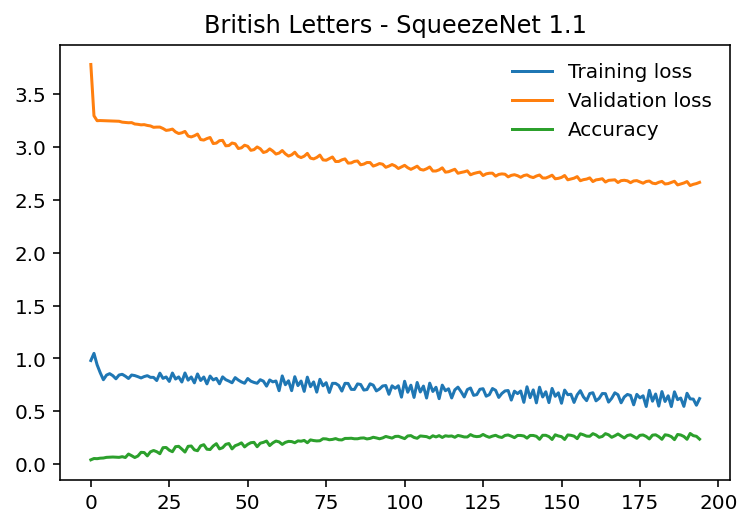

Epoch 51/300.. Train loss: 2.554.. Test loss: 2.629.. Test accuracy: 0.279
Epoch 51/300.. Train loss: 2.317.. Test loss: 2.642.. Test accuracy: 0.274
Epoch 51/300.. Train loss: 2.222.. Test loss: 2.648.. Test accuracy: 0.254
Epoch 51/300.. Time: 22.391
Epoch 52/300.. Train loss: 2.440.. Test loss: 2.659.. Test accuracy: 0.240
Epoch 52/300.. Train loss: 2.504.. Test loss: 2.626.. Test accuracy: 0.276
Epoch 52/300.. Train loss: 2.203.. Test loss: 2.642.. Test accuracy: 0.273
Epoch 52/300.. Train loss: 2.308.. Test loss: 2.645.. Test accuracy: 0.254
Epoch 52/300.. Time: 25.449
Epoch 53/300.. Train loss: 2.468.. Test loss: 2.649.. Test accuracy: 0.259
Epoch 53/300.. Train loss: 2.461.. Test loss: 2.622.. Test accuracy: 0.285
Epoch 53/300.. Train loss: 2.132.. Test loss: 2.643.. Test accuracy: 0.273
Epoch 53/300.. Train loss: 2.318.. Test loss: 2.646.. Test accuracy: 0.246
Epoch 53/300.. Time: 25.486
Epoch 54/300.. Train loss: 2.509.. Test loss: 2.642.. Test accuracy: 0.263
Epoch 54/300.. T

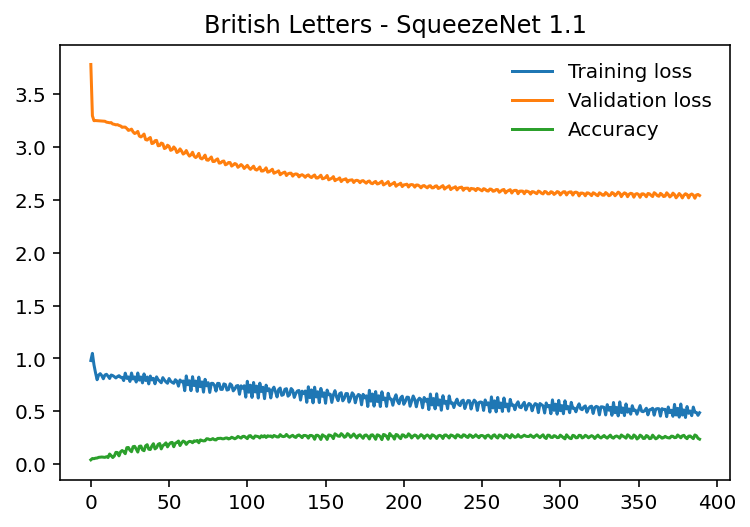

Epoch 101/300.. Train loss: 2.063.. Test loss: 2.519.. Test accuracy: 0.269
Epoch 101/300.. Train loss: 1.906.. Test loss: 2.553.. Test accuracy: 0.263
Epoch 101/300.. Train loss: 1.881.. Test loss: 2.556.. Test accuracy: 0.240
Epoch 101/300.. Time: 22.105
Epoch 102/300.. Train loss: 1.936.. Test loss: 2.539.. Test accuracy: 0.235
Epoch 102/300.. Train loss: 2.007.. Test loss: 2.522.. Test accuracy: 0.265
Epoch 102/300.. Train loss: 1.765.. Test loss: 2.557.. Test accuracy: 0.265
Epoch 102/300.. Train loss: 1.961.. Test loss: 2.553.. Test accuracy: 0.247
Epoch 102/300.. Time: 24.778
Epoch 103/300.. Train loss: 1.949.. Test loss: 2.532.. Test accuracy: 0.241
Epoch 103/300.. Train loss: 2.014.. Test loss: 2.526.. Test accuracy: 0.268
Epoch 103/300.. Train loss: 1.738.. Test loss: 2.556.. Test accuracy: 0.260
Epoch 103/300.. Train loss: 1.943.. Test loss: 2.546.. Test accuracy: 0.249
Epoch 103/300.. Time: 24.662
Epoch 104/300.. Train loss: 1.958.. Test loss: 2.524.. Test accuracy: 0.241
E

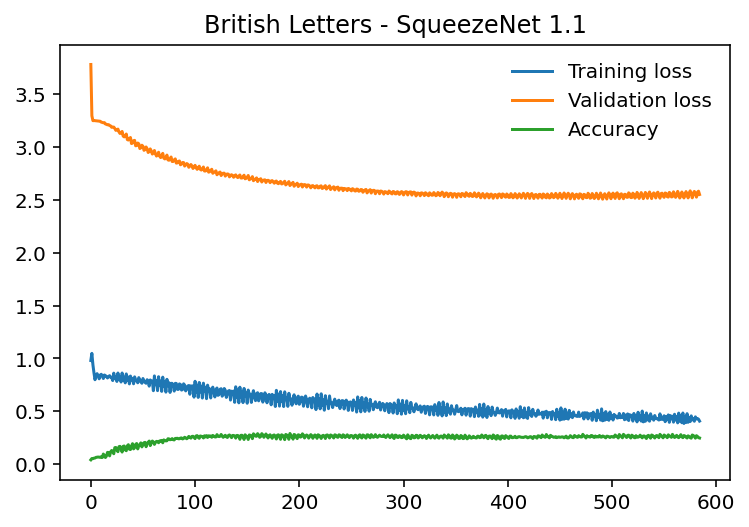

Epoch 151/300.. Train loss: 1.800.. Test loss: 2.526.. Test accuracy: 0.274
Epoch 151/300.. Train loss: 1.606.. Test loss: 2.568.. Test accuracy: 0.268
Epoch 151/300.. Train loss: 1.673.. Test loss: 2.575.. Test accuracy: 0.260
Epoch 151/300.. Time: 21.732
Epoch 152/300.. Train loss: 1.607.. Test loss: 2.542.. Test accuracy: 0.252
Epoch 152/300.. Train loss: 1.736.. Test loss: 2.531.. Test accuracy: 0.276
Epoch 152/300.. Train loss: 1.515.. Test loss: 2.580.. Test accuracy: 0.268
Epoch 152/300.. Train loss: 1.738.. Test loss: 2.574.. Test accuracy: 0.254
Epoch 152/300.. Time: 24.682
Epoch 153/300.. Train loss: 1.619.. Test loss: 2.537.. Test accuracy: 0.255
Epoch 153/300.. Train loss: 1.735.. Test loss: 2.535.. Test accuracy: 0.272
Epoch 153/300.. Train loss: 1.542.. Test loss: 2.581.. Test accuracy: 0.265
Epoch 153/300.. Train loss: 1.729.. Test loss: 2.571.. Test accuracy: 0.247
Epoch 153/300.. Time: 24.884
Epoch 154/300.. Train loss: 1.589.. Test loss: 2.533.. Test accuracy: 0.260
E

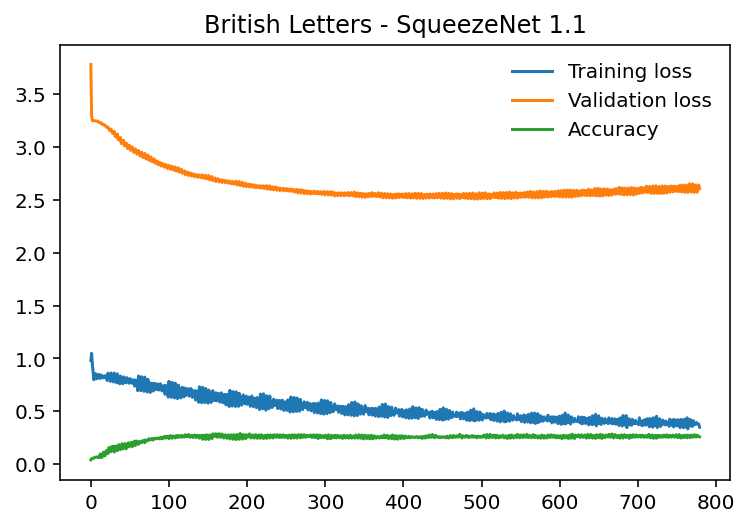

Epoch 201/300.. Train loss: 1.603.. Test loss: 2.582.. Test accuracy: 0.276
Epoch 201/300.. Train loss: 1.400.. Test loss: 2.634.. Test accuracy: 0.257
Epoch 201/300.. Train loss: 1.514.. Test loss: 2.642.. Test accuracy: 0.250
Epoch 201/300.. Time: 21.971
Epoch 202/300.. Train loss: 1.356.. Test loss: 2.604.. Test accuracy: 0.255
Epoch 202/300.. Train loss: 1.544.. Test loss: 2.587.. Test accuracy: 0.272
Epoch 202/300.. Train loss: 1.379.. Test loss: 2.646.. Test accuracy: 0.252
Epoch 202/300.. Train loss: 1.576.. Test loss: 2.645.. Test accuracy: 0.252
Epoch 202/300.. Time: 25.220
Epoch 203/300.. Train loss: 1.396.. Test loss: 2.600.. Test accuracy: 0.257
Epoch 203/300.. Train loss: 1.622.. Test loss: 2.590.. Test accuracy: 0.274
Epoch 203/300.. Train loss: 1.361.. Test loss: 2.650.. Test accuracy: 0.254
Epoch 203/300.. Train loss: 1.577.. Test loss: 2.639.. Test accuracy: 0.252
Epoch 203/300.. Time: 25.251
Epoch 204/300.. Train loss: 1.385.. Test loss: 2.590.. Test accuracy: 0.265
E

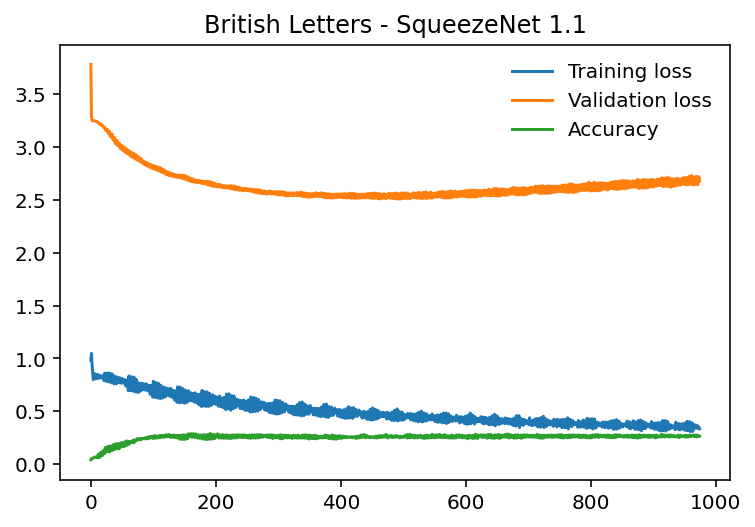

Epoch 251/300.. Train loss: 1.497.. Test loss: 2.639.. Test accuracy: 0.277
Epoch 251/300.. Train loss: 1.275.. Test loss: 2.702.. Test accuracy: 0.268
Epoch 251/300.. Train loss: 1.436.. Test loss: 2.715.. Test accuracy: 0.271
Epoch 251/300.. Time: 22.509
Epoch 252/300.. Train loss: 1.259.. Test loss: 2.673.. Test accuracy: 0.263
Epoch 252/300.. Train loss: 1.458.. Test loss: 2.657.. Test accuracy: 0.269
Epoch 252/300.. Train loss: 1.236.. Test loss: 2.717.. Test accuracy: 0.261
Epoch 252/300.. Train loss: 1.506.. Test loss: 2.717.. Test accuracy: 0.266
Epoch 252/300.. Time: 25.734
Epoch 253/300.. Train loss: 1.279.. Test loss: 2.668.. Test accuracy: 0.261
Epoch 253/300.. Train loss: 1.489.. Test loss: 2.652.. Test accuracy: 0.271
Epoch 253/300.. Train loss: 1.285.. Test loss: 2.716.. Test accuracy: 0.258
Epoch 253/300.. Train loss: 1.460.. Test loss: 2.712.. Test accuracy: 0.266
Epoch 253/300.. Time: 25.624
Epoch 254/300.. Train loss: 1.290.. Test loss: 2.660.. Test accuracy: 0.268
E

In [ ]:
epochs = 300
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses, accuracy_lst = [], [], []

for epoch in range(epochs):
    start = time.time()
    
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader)) 
            accuracy_lst.append(accuracy/len(testloader))                   
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
            
    end = time.time()
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time: {end-start:.3f}")
    
    if (epoch+1) % 50 == 0:
      torch.save(model, f'russian_{model_name}_{epoch+1}.pth')
      !cp 'russian_{model_name}_{epoch+1}.pth' /content/gdrive/MyDrive/Classification/Russian/v5/squeezenet1_1/

      plt.plot(train_losses, label='Training loss')
      plt.plot(test_losses, label='Validation loss')
      plt.plot(accuracy_lst, label='Accuracy')
      plt.title('British Letters - SqueezeNet 1.1')
      plt.legend(frameon=False)
      plt.show()

## Plot loss

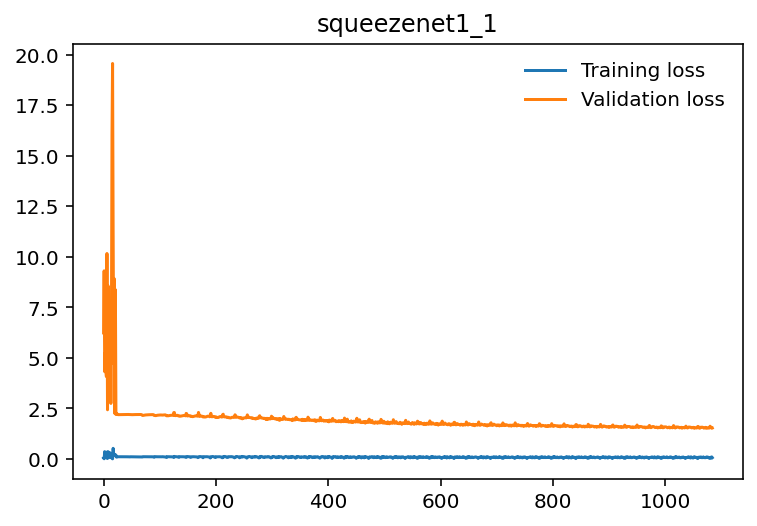

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title(model_name)
plt.legend(frameon=False)
plt.show()

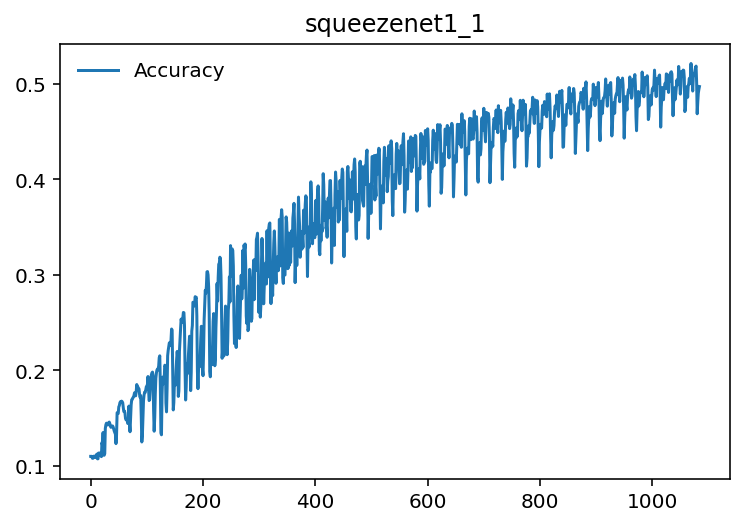

In [ ]:
plt.plot(accuracy_lst, label='Accuracy')
plt.title(model_name)
plt.legend(frameon=False)
plt.show()

# Train from last stop

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from torch.autograd import Variable

%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

%cd content

!mkdir data
!cp /content/gdrive/MyDrive/Classification/City/v4/data/train.zip ./
!cp /content/gdrive/MyDrive/Classification/City/v4/data/valid.zip ./
!unzip ./train.zip -d data/
!unzip ./valid.zip -d data/

data_dir_train = 'data/train'
data_dir_valid = 'data/valid'

def load_split_train_test(datadirtrain, datadirtest):
    
    train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],)
                                       ])    
    
    test_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],)
                                       ])    
    
    train_data = datasets.ImageFolder(datadirtrain,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadirtest,
                    transform=test_transforms)    
    
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=64)
    
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir_train, data_dir_valid)
print(trainloader.dataset.classes)

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/train/Newcastle/SafeRotate_015_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_016_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_017_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_018_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_020_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_023_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_026_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_027_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_028_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_029_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_030_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_033_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_034_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_035_Newcastle.jpg  
  inflating: data/trai

In [ ]:
!cp /content/gdrive/MyDrive/Classification/City/v4/squeezenet1_1/city_squeezenet1_1_100.pth ./
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load(f'city_{model_name}_100.pth')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)
model

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [ ]:
import time
# from torchvision.models.squeezenet import squeezenet1_1
epochs = 50
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses, accuracy_lst = [], [], []

for epoch in range(epochs):
    start = time.time()
    
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader)) 
            accuracy_lst.append(accuracy/len(testloader))                   
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
            
    end = time.time()
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time: {end-start:.3f}")
    
    if (epoch+1) % 50 == 0:
      torch.save(model, f'city_{model_name}_{epoch+101}.pth')
      !cp 'city_{model_name}_{epoch+101}.pth' /content/gdrive/MyDrive/Classification/City/v4/squeezenet1_1/

Epoch 1/50.. Train loss: 1.708.. Test loss: 1.431.. Test accuracy: 0.555
Epoch 1/50.. Train loss: 1.134.. Test loss: 1.475.. Test accuracy: 0.550
Epoch 1/50.. Train loss: 1.155.. Test loss: 1.505.. Test accuracy: 0.550
Epoch 1/50.. Train loss: 1.202.. Test loss: 1.531.. Test accuracy: 0.550
Epoch 1/50.. Train loss: 1.542.. Test loss: 1.561.. Test accuracy: 0.548
Epoch 1/50.. Train loss: 1.875.. Test loss: 1.602.. Test accuracy: 0.534
Epoch 1/50.. Train loss: 1.315.. Test loss: 1.635.. Test accuracy: 0.524
Epoch 1/50.. Train loss: 1.501.. Test loss: 1.640.. Test accuracy: 0.518
Epoch 1/50.. Train loss: 1.296.. Test loss: 1.642.. Test accuracy: 0.512
Epoch 1/50.. Train loss: 1.595.. Test loss: 1.643.. Test accuracy: 0.505
Epoch 1/50.. Train loss: 1.783.. Test loss: 1.638.. Test accuracy: 0.515
Epoch 1/50.. Train loss: 1.776.. Test loss: 1.631.. Test accuracy: 0.517
Epoch 1/50.. Train loss: 1.844.. Test loss: 1.629.. Test accuracy: 0.523
Epoch 1/50.. Train loss: 1.687.. Test loss: 1.623..

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title(model_name)
plt.legend(frameon=False)
plt.show()

In [ ]:
plt.plot(accuracy_lst, label='Accuracy')
plt.title(model_name)
plt.legend(frameon=False)
plt.show()

# Test

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from torch.autograd import Variable

In [ ]:
data_dir = '/content/gdrive/MyDrive/Classification/Letter/v2/data/test'

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])
                                     ])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load(f'letters_{model_name}.pth')
model.eval()
model

In [ ]:


def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index  

def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels



In [ ]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()